# Pru Wealth Data Test

Below we will explore a mock database of customers, policies and funds that are similar to the Pru Wealth data. The first section of this notebook will test your SQL skills, the second section will test your Python skills and visualisation skills.

The database file is called Prudential_Data.db

The three tables included in this database are:
* Customer_Table
* Policy_Table
* Fund_Table

You will need to have the following packages installed in your Python environment:
* numpy
* pandas
* sqlite3

For visualization use any package of your choice (e.g., matplotlib, seaborn, plotly).

Please complete and return the test before the deadline by emailing your copy of this notebook to: Denholm.Hesse@Prudential.co.uk. If you do not know the answer to a question feel free to use Google and Stack Overflow. This is to give you the option to teach yourself a concept from the internet to address a question which you do not know the answer to, please refrain from skipping questions. The test is meant to be completed by you only.

Good luck and have fun!

In [710]:
import numpy as np
import pandas as pd
import sqlite3
import re
import seaborn as sns
import matplotlib.pyplot as mplt
import matplotlib.patches as mpatches
import datetime as dt

SyntaxError: invalid syntax (<ipython-input-710-f56c475fad08>, line 9)

# SQL test

IMPORANT: Please make sure all questions in this section are solved using SQL by only editing the content of the variable *sqlite_query*. Please do not edit the below cell:

In [587]:
# Establish DB connection
conn = sqlite3.connect('Prudential_Data.db')

Below is an example of how to query the SQLlite databse from this Jupyter notebook. Please note that SQLlite might have a slightly different syntax from the SQL you normally use. Please do not edit the below cell:

In [588]:
sqlite_query = """
SELECT COUNT(*) 
from policy_table 
"""

pd.read_sql(sqlite_query, conn)

,COUNT(*)
0,1635


The first table "Customer_Table" contains personal information about the customers. Please do not edit the below cell:

In [589]:
sqlite_query = """
SELECT * 
from Customer_Table 
limit 5
"""

pd.read_sql(sqlite_query, conn)

,index,Customer ID,Email,Gender,Age,Postcode
0,0,CO183683,NLUPPITT14@PARALLELS.COM,Male,90,None
1,1,CO314757,None,Female,90,None
2,2,CO720602,None,Female,90,None
3,3,CO34804,None,Female,90,1495-701
4,4,CO474411,None,Male,90,301288


The second table "Policy_Table" contains data relating to customer policies. The policy value is the current value of the policy. Please do not edit the below cell:

In [590]:
sqlite_query = """
SELECT SUM("Policy Value") 
from Policy_Table 
"""

pd.read_sql(sqlite_query, conn)

,"SUM(""Policy Value"")"
0,507178017.0


The final table "Fund_Table" contains historic data on the Policy Value (Policy_Value_Snapshot). The Policy_Value_Snapshot represents the value of the policy and the Date column is the date at which that value was recorded. The value may have changed overtime due to changes in the fund price or quanity of units the policy was invested in. Please do not edit the below cell:

In [46]:
sqlite_query = """
SELECT 
*
from Fund_Table
limit 5

"""

pd.read_sql(sqlite_query, conn)

,index,Policy Number,Customer ID,Date,Product Category,Product Name,Policy_Value_Snapshot
0,0,ANN1221,CO408564,2009-10-31 00:00:00,ANNUITY,STANDARD ANNUITY,None
1,1,ANN1221,CO408564,2009-11-30 00:00:00,ANNUITY,STANDARD ANNUITY,None
2,2,ANN1221,CO408564,2009-12-31 00:00:00,ANNUITY,STANDARD ANNUITY,None
3,3,ANN1221,CO408564,2010-01-31 00:00:00,ANNUITY,STANDARD ANNUITY,None
4,4,ANN1221,CO408564,2010-02-28 00:00:00,ANNUITY,STANDARD ANNUITY,None


If a question requires additional explanation for your answer, please add additional cells below the code. 

## Q1: What is the current average policy value split by each product name? 

In [47]:
sqlite_query = """
SElect  "Product Name",ROUND(AVG(IFNULL("Policy Value",0)),1) AS "AVERAGE POLICY VALUE"
FROM Policy_Table
GROUP BY "Product Name"

"""

pd.read_sql(sqlite_query, conn)

,Product Name,AVERAGE POLICY VALUE
0,CORPORATE MEMBERSHIP,5697.3
1,FOCUSSED ISA,5746.3
2,NHS PENSION,5241.5
3,PRU BOND,4516.4
4,PRUDENTIAL INVESTMENT PLAN,5084.5
5,PRUDENTIAL ISA,5161.1
6,RETIREMENT ACCOUNT,504965.0
7,SIPP,5335.8
8,STANDARD ANNUITY,0.0


## Q2: How many customers opened a new policy in Q1 2017 who already had an existing pension product? 

In [184]:
sqlite_query = """
SELECT COUNT(distinct "Customer ID" ) AS "Repeat Customer Q1 2017 with Pension Product"
FROM Policy_Table
WHERE "Policy Start Date" >= "2017-01-01" and "Policy Start Date" <= '2017-03-31'
and "Customer ID" in (SELECT "Customer ID" AS "Repeat Customer Q1 107"
FROM Policy_Table
WHERE "Policy Start Date" < '2017-01-01' and "PRODUCT CATEGORY" = 'PENSION')

"""
sqlite_query = """
SELECT * 
from Customer_Table where "Customer ID" = 'CO276506'
"""

pd.read_sql(sqlite_query, conn)

,index,Customer ID,Email,Gender,Age,Postcode
0,33,CO276506,None,Female,87,None


## Q3: What was the customer ID that had the biggest difference in policy value between its earliest and latest date (for any product) ?

In [143]:
# Considering single policy for a customer
sqlite_query = """
SELECT  X."Customer ID",X."Policy Number" , IFNULL(MAX.Policy_Value_Snapshot,0) - IFNULL(MIN.Policy_Value_Snapshot,0) AS ValueDiff 
FROM
(
SELECT "Customer ID","Policy Number",MIN(DATE) as EarliestDate,MAx(DATE) as LatestDate 
FROM Fund_Table
GROUP BY "Customer ID","Policy Number"
)X
INNER JOIN Fund_Table MIN ON X."Policy Number" = MIN."Policy Number" and X."Customer ID"= MIN."Customer ID" and X.EarliestDate = MIN.DATE 
INNER JOIN Fund_Table MAX ON X."Policy Number" = MAX."Policy Number" and X."Customer ID"= MAX."Customer ID"and X.LatestDate = MAX.DATE
ORDER BY ValueDiff DESC LIMIT 1

"""

pd.read_sql(sqlite_query, conn)

,Customer ID,Policy Number,ValueDiff
0,CO401070,RET100479,943283.5


In [146]:
# Considering  all the policies for a customer
sqlite_query = """
SELECT "Customer ID" ,ROUND(ValueDiff,1) as ValueDiff
FROM 
(
SELECT  X."Customer ID",SUM(IFNULL(MAX.Policy_Value_Snapshot,0) - IFNULL(MIN.Policy_Value_Snapshot,0)) AS ValueDiff 
FROM
(
SELECT "Customer ID","Policy Number",MIN(DATE) as EarliestDate,MAx(DATE) as LatestDate 
FROM Fund_Table
GROUP BY "Customer ID","Policy Number"
)X
INNER JOIN Fund_Table MIN ON X."Policy Number" = MIN."Policy Number" and X."Customer ID"= MIN."Customer ID" and X.EarliestDate = MIN.DATE 
INNER JOIN Fund_Table MAX ON X."Policy Number" = MAX."Policy Number" and X."Customer ID"= MAX."Customer ID"and X.LatestDate = MAX.DATE
GROUP BY X."Customer ID"
)Y
ORDER BY ValueDiff DESC LIMIT 1

"""


pd.read_sql(sqlite_query, conn)

,Customer ID,ValueDiff
0,CO401070,923603.4


# Python Test

Same data, but now let's have some fun in python. Please do not use SQL for this part of the exercise. 

Feel free to add more cells of code or text

In [728]:
Customer_Table = pd.read_sql('SELECT * FROM Customer_Table', conn)
Policy_Table = pd.read_sql('SELECT * FROM Policy_Table', conn)
Fund_Table = pd.read_sql('SELECT * FROM Fund_Table', conn)

## Q4: Produce a list of customers which have an invalid email address. What do you notice about these customers? ##

Feel free to use any packages of your choice

In [211]:
#Ans 1 Considering None as invalid
#Insert your answer below: 
def Is_ValidEmail(email):
    """
    This function retuns true if Emal id is valid
    """
    if(pd.notna(email)): 
        regex = '^(\w|\.|\_|\-)+[@](\w|\_|\-|\.)+[.]\w{2,3}$'  #Valid email regex
        if(re.search(regex,email)):
            return True
        else:
            return False
    return False

Customer_Table_temp=Customer_Table
Customer_Table_temp['ValidEmail']= Customer_Table['Email'].apply(Is_ValidEmail)
Customer_Table_Invalid_Email =  Customer_Table_temp[~(Customer_Table_temp['ValidEmail'])]
Customer_Table_Invalid_Email_Policies = pd.merge(Policy_Table,Customer_Table_invalid_email,on="Customer ID",how='inner')
#Customer_Table_Invalid_Email_Policies.to_csv('C:\Test\Customer_2.csv')
Customer_Table_Invalid_Email_Policies
#del Customer_Table_temp,Customer_Table_Invalid_Email,Customer_Table_Invalid_Email_Policies
#Total 55 customer with Invalid email IDs All Cusomers that have invalid email id atleast one of the policies is 'Retirement Account'


,index_x,Policy Number,Customer ID,Product Category,Product Name,Policy Value,Policy Start Date,index_y,Email,Gender,Age,Postcode,ValidEmail
0,0,RET100072,CO276506,RETIREMENT,RETIREMENT ACCOUNT,270033.0,2016-01-02 00:00:00,33,None,Female,87,None,False
1,999,ISA7852,CO276506,ISA,PRUDENTIAL ISA,5074.0,2010-03-13 00:00:00,33,None,Female,87,None,False
2,10,RET100669,CO825106,RETIREMENT,RETIREMENT ACCOUNT,217076.0,2016-01-18 00:00:00,367,None,Female,65,59-225,False
3,1009,ISA7313,CO825106,ISA,PRUDENTIAL ISA,9314.0,2014-07-29 00:00:00,367,None,Female,65,59-225,False
4,60,RET100239,CO797073,RETIREMENT,RETIREMENT ACCOUNT,901170.0,2016-03-11 00:00:00,37,None,Female,87,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,921,RET100358,CO34681,RETIREMENT,RETIREMENT ACCOUNT,724006.0,2018-10-01 00:00:00,72,None,Male,85,None,False
84,947,RET100004,CO360302,RETIREMENT,RETIREMENT ACCOUNT,168510.0,2018-10-29 00:00:00,76,None,Female,84,2980,False
85,949,RET100534,CO28776,RETIREMENT,RETIREMENT ACCOUNT,2577.0,2018-10-30 00:00:00,41,None,Male,87,7019,False
86,956,RET100728,CO155821,RETIREMENT,RETIREMENT ACCOUNT,163081.0,2018-11-08 00:00:00,491,None,Male,64,521 96,False


In [212]:
#Ans 2 Considering None as empty and hence valid
#Insert your answer below: 
def Is_ValidEmail1(email):
    """
    This function retuns true if Emal id is valid
    """
    if(email is not None or pd.notna(email) ): 
        regex = '^(\w|\.|\_|\-)+[@](\w|\_|\-|\.)+[.]\w{2,3}$'  #Valid email regex
        if(re.search(regex,email)):
            return True
        else:
            return False
    return True

Customer_Table_temp1 = Customer_Table
Customer_Table_temp1['ValidEmail']= Customer_Table_temp1['Email'].apply(Is_ValidEmail1)
Customer_Table_Invalid_Email1 =  Customer_Table_temp1[~(Customer_Table_temp1['ValidEmail'])]
Customer_Table_Invalid_Email_Policies1 = pd.merge(Customer_Table_Invalid_Email1,Policy_Table,on="Customer ID",how='inner')
#Customer_Table_Invalid_Email_Policies1.to_csv('C:\Test\Customer_invalid.csv')
Customer_Table_Invalid_Email_Policies1
del Customer_Table_temp1,Customer_Table_Invalid_Email1,Customer_Table_Invalid_Email_Policies1
#Total 7 customer with Invalid email IDs. All Cusomers that have invalid email id atleast one of the policies is 'Retirement Account'




## Q5: The Managing Director of Pru Wealth needs to see how policy value differs between other variables in the database (e.g. customer demographics) . They don't have time to read a report, so have asked for a cool visualisation that tells a story.

Visualise something cool, tell us a story! You can use packages like Matplotlib, Seaborn or Plotly.Tell us why you chose to visualise the data in this way and how it can be used from a business perspective.


# Insert your answer below: 
# Gender-wise distribution of Policy Value


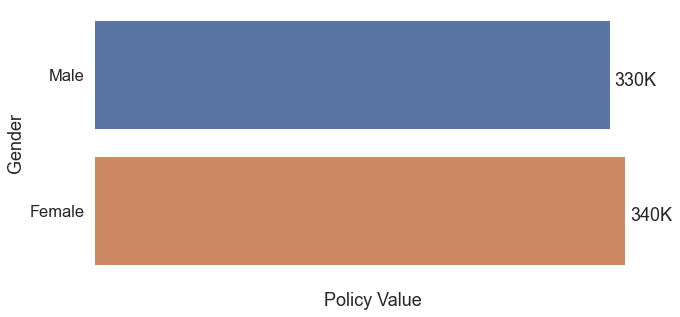

In [828]:
# Insert your answer below: 
#Customer Demographics By Gender
def safe_num(num):
    """
    This function converts valid string or int to float
    """
    if isinstance(num, str):
        num = float(num)
    return float('{:.3g}'.format(abs(num)))
def Format_Num(num):
    """
    This function converts number to K ,M values
    """
    num = safe_num(num)
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])




Customer_Policy_Value =  pd.merge(Customer_Table,Policy_Table,on="Customer ID",how='inner')
Customer_Policy_Value_sum= Customer_Policy_Value.groupby('Gender')['Policy Value'].sum().reset_index()

sns.set_style("white", {'axes.grid' : False})
plt = sns.barplot(y= "Gender",x="Policy Value",data=Customer_Policy_Value,ci=None)
plt.set(xticklabels=[])
for p in plt.patches:
    width = p.get_width()
    plt.text(p.get_width()+.05*p.get_width(), p.get_y()+0.55*p.get_height(),
             Format_Num(width),
             ha='center', va='center')
sns.despine(left=True, bottom=True, right=True)


# Obsevation - Policy value is evenly distributed Among Genders

# Age group distribution of Policy Value

In [889]:
#Customer Demographics By Gender(Customer Count)
# create age bins
df_ages = pd.DataFrame({'Age':range(0,111)})
df_ages['Age Group'] = pd.cut(x=df_ages['Age'], bins=[*range(0,120,10)],right=False,include_lowest=True )
Customer_Policy_Value_Age_Bins = pd.merge(Customer_Policy_Value,df_ages[['Age','Age Group']],on ='Age',how='left')
Customer_Policy_Value_Age_Bins_sum= Customer_Policy_Value_Age_Bins.groupby('Age Group')['Policy Value'].sum().reset_index()
Customer_Policy_Value_Age_Bins_sum = Customer_Policy_Value_Age_Bins_sum[Customer_Policy_Value_Age_Bins_sum['Policy Value'] >0]
minval = Customer_Policy_Value_Age_Bins_sum['Policy Value'].min()
Customer_Policy_Value_Age_Bins_sum=Customer_Policy_Value_Age_Bins_sum[Customer_Policy_Value_Age_Bins_sum['Policy Value'] >0]
minval = Customer_Policy_Value_Age_Bins_sum['Policy Value'].min()


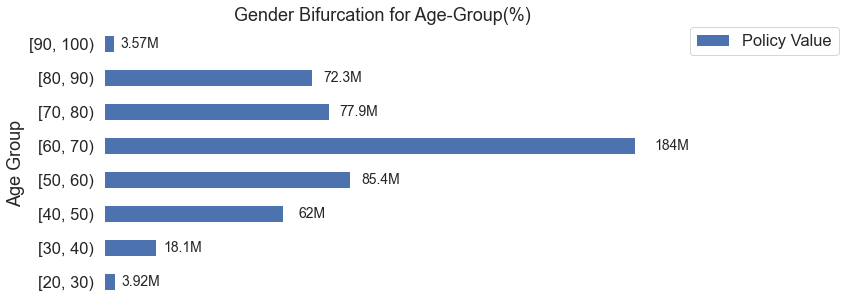

In [890]:

#Plot the bar Chart
sns.set_style("whitegrid", {'axes.grid' : False})

plt2 =Customer_Policy_Value_Age_Bins_sum.plot(
    x = 'Age Group',
    kind = 'barh',
    stacked = True,
    mark_right = True,title='Gender Bifurcation for Age-Group(%)')
#plt2 = sns.plot(y= 'Age Group',x="Policy Value",data=Customer_Policy_Value_Age_Bins_sum,label = 'Policy Value',color="tab:blue",ci=None)
#plt2.set(xticklabels=[])
for p in plt2.patches:
    width = p.get_width()
    plt2.text(2.5*minval+p.get_width()+.02*p.get_width(), p.get_y()+0.5*p.get_height(),
             Format_Num(width),
             ha='center', va='center',fontsize=14)
plt2.xaxis.set_visible(False)

mplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
mplt.box(False)

# Observation -  Age Group distribution follows bell Curve with peak in age group of 60-70 years 

# Age Group -Gender Distribution Raw Values

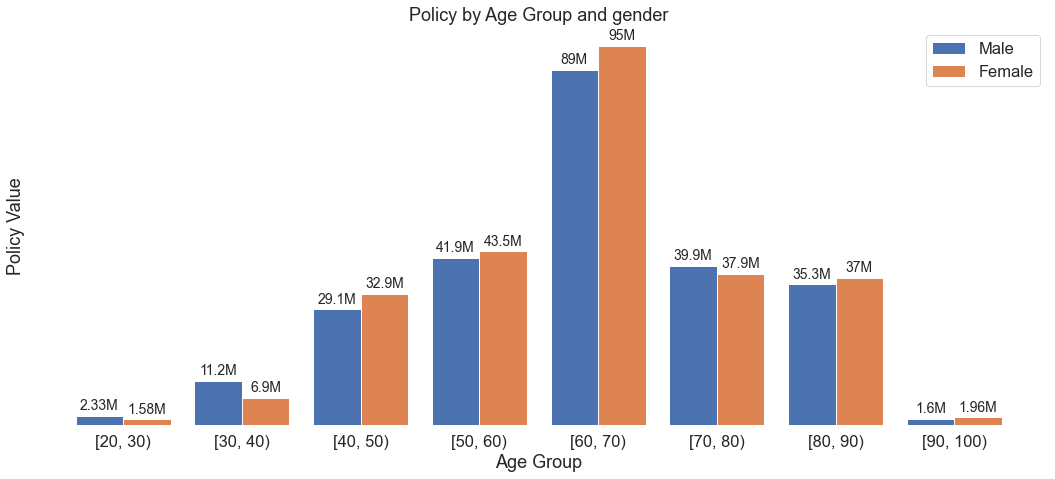

In [943]:
Female = Customer_Policy_Value_Age_Bins[Customer_Policy_Value_Age_Bins.Gender=='Female'].groupby('Age Group')['Policy Value'].sum().reset_index()
Male = Customer_Policy_Value_Age_Bins[Customer_Policy_Value_Age_Bins.Gender=='Male'].groupby('Age Group')['Policy Value'].sum().reset_index()
Final =  pd.merge(Male[['Age Group','Policy Value']],Female[['Age Group','Policy Value']],on ='Age Group',how='outer')
Final.rename(columns={'Policy Value_x':'Male','Policy Value_y':'Female'},inplace  = True)
Final = Final[(Final['Male'] > 0) & (Final['Female'] > 0)]


Age_group = Final['Age Group']
Male = Final['Male']
Female = Final['Female']

x = np.arange(len(Age_group))  # the label locations
width = 0.4  # the width of the bars

fig, ax = mplt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, Male, width, label='Male')
rects2 = ax.bar(x + width/2, Female, width, label='Female')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Policy Value')
ax.set_xlabel('Age Group')
ax.set_yticks([])
ax.set_title('Policy by Age Group and gender')
ax.set_xticks(x)
ax.set_xticklabels(Age_group)
ax.legend()
for p in ax.patches:
    mplt.annotate(Format_Num(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points',fontsize=14)
fig.tight_layout()
mplt.box(False)
mplt.show()


# Age Group -Gender Distribution Percentages

<Figure size 1440x1440 with 0 Axes>

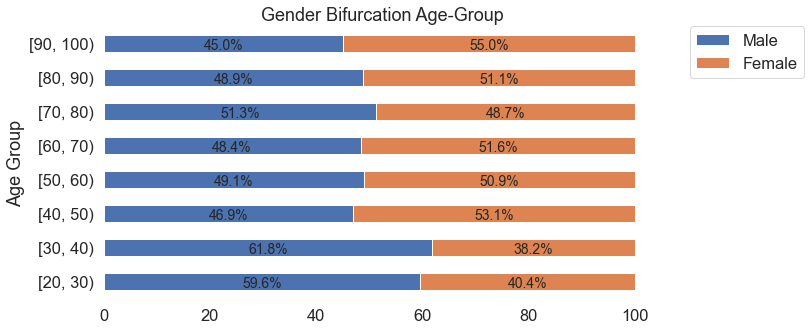

In [853]:
def ndivide(a,b):
    """
    Divion function to divide by Zero
    """
    c = ( a /b ) if a+b != 0 else 0
    return c
mplt.figure(figsize=(20, 20))
# pivot the value data
Female = Customer_Policy_Value_Age_Bins[Customer_Policy_Value_Age_Bins.Gender=='Female'].groupby('Age Group')['Policy Value'].sum().reset_index()
Male = Customer_Policy_Value_Age_Bins[Customer_Policy_Value_Age_Bins.Gender=='Male'].groupby('Age Group')['Policy Value'].sum().reset_index()
Total =  Customer_Policy_Value_Age_Bins.groupby('Age Group')['Policy Value'].sum().reset_index()
Male['Policy Value'] = [ndivide(i , j) * 100 for i,j in zip(Male['Policy Value'], Total['Policy Value'])]
Female['Policy Value'] = [ndivide(i , j) * 100 for i,j in zip(Female['Policy Value'], Total['Policy Value'])]
Final =  pd.merge(Male[['Age Group','Policy Value']],Female[['Age Group','Policy Value']],on ='Age Group',how='outer')
Final.rename(columns={'Policy Value_x':'Male','Policy Value_y':'Female'},inplace  = True)
Final = Final[(Final['Male'] > 0) & (Final['Female'] > 0)]

Final.plot(
    x = 'Age Group',
    kind = 'barh',
    stacked = True,
    mark_right = True,title='Gender Bifurcation for Age-Group(%)')

df_total = Final["Male"] + Final["Female"]
df_rel = Final[Final.columns[1:]].div(df_total, 0)*100
  
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(Final.iloc[:, 1:].cumsum(1)[n], 
                                         Final[n], df_rel[n])):
        mplt.text(cs - ab / 2, i-0.05, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'center',fontsize=14)
mplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
mplt.box(False)



# Observation - For Younger Age Group Male Policy holders have larger Policy values while the difference diminishes as the age group increases

# Policy value by Product Name and Category

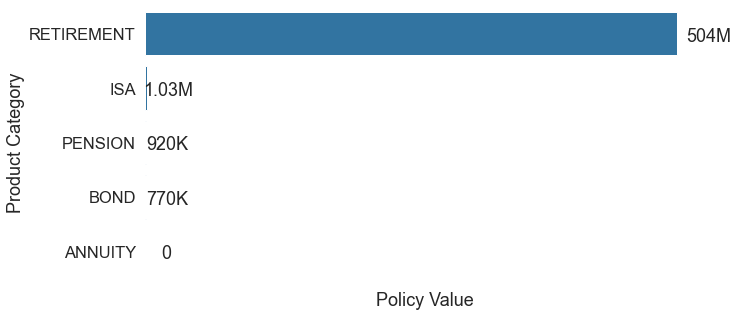

In [681]:
Product_distribution = Customer_Policy_Value_Age_Bins.groupby('Product Category').sum('Policy Value').reset_index().sort_values('Policy Value',ascending = False)
plt1 = sns.barplot(y= 'Product Category',x="Policy Value",data=Product_distribution,label = True,color="tab:blue",ci=None)
plt1.set(xticklabels=[])
maxval = Product_distribution['Policy Value'].max()

for p in plt1.patches:
    width = p.get_width()
    plt1.text( .04*maxval+p.get_width()+.02*p.get_width(), p.get_y()+0.55*p.get_height(),
             Format_Num(width),
             ha='center', va='center')

mplt.box(False)


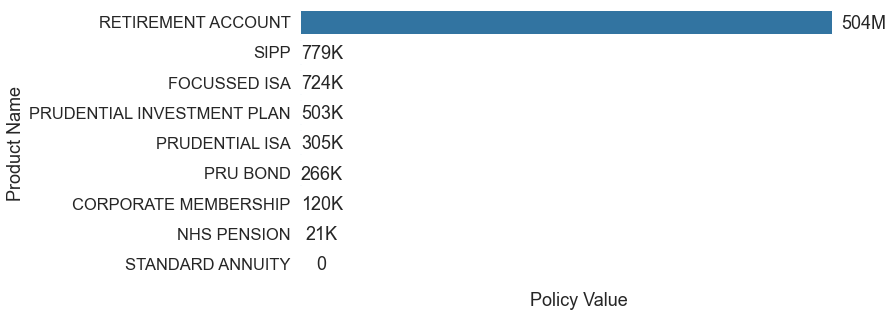

In [694]:
Product_distribution_Name = Customer_Policy_Value_Age_Bins.groupby('Product Name').sum('Policy Value').reset_index().sort_values('Policy Value',ascending = False)

plt1 = sns.barplot(y= 'Product Name',x="Policy Value",data=Product_distribution_Name,label = True,color="tab:blue",ci=None)
plt1.set(xticklabels=[])
maxval = Product_distribution_Name['Policy Value'].max()
for p in plt1.patches:
    width = p.get_width()
    plt1.text( .04*maxval+p.get_width()+.02*p.get_width(), p.get_y()+0.55*p.get_height(),
             Format_Num(width),
             ha='center', va='center')

mplt.box(False)


# Policy Value and Count tred

In [885]:
def getmonthyear(date):
    """
    Converts date to YYYYMM format
    """
    datetemp= dt.datetime.strptime(date,"%Y-%m-%d %H:%M:%S")
    quarter  = datetemp.month//4+1
    return int(datetemp.strftime('%Y'))


Fund_Table_temp =Fund_Table
Fund_Table_temp['YearMonth'] = Fund_Table_temp['Date'].apply(getmonthyear)
Fund_Table_temp

Fund_Table_temp1 = Fund_Table_temp.groupby('YearMonth').agg(Policycount=('Policy Number', 'count'), Policy_Value=('Policy_Value_Snapshot', 'sum')).reset_index()
Fund_Table_temp1['Average_Policy_Value'] = Fund_Table_temp1['Policy_Value']/Fund_Table_temp1['Policycount']


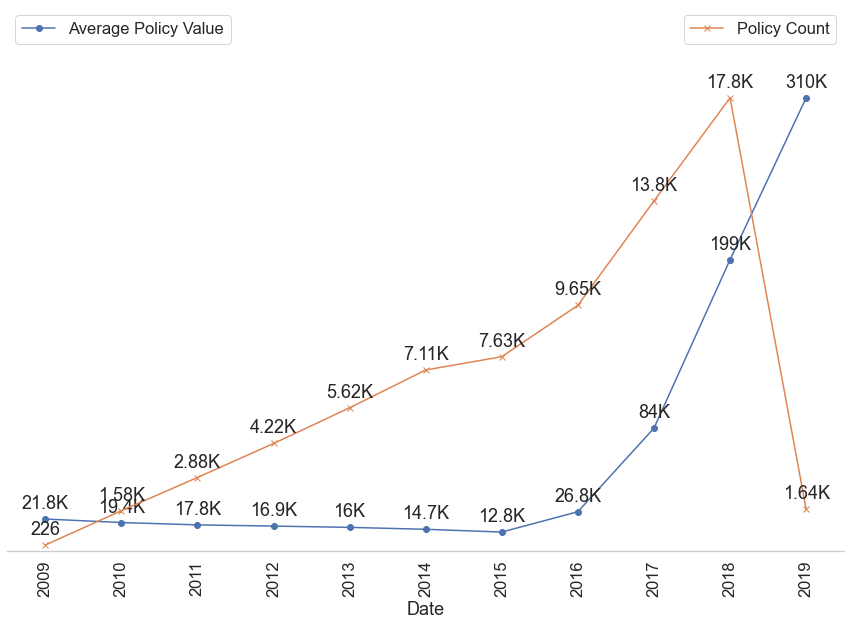

In [940]:

fig, ax1 = mplt.subplots(figsize=(15,10))
xdate = [x for x in Fund_Table_temp1['YearMonth']]
Average_Policy_Value = [x for x in Fund_Table_temp1['Average_Policy_Value']]
Policycount = [x for x in Fund_Table_temp1['Policycount']]
ax1.set_xlabel('Date')
ax1.plot(xdate,Average_Policy_Value, label="Average Policy Value",marker='o',color ='#4c72b0')
ax1.tick_params(axis='x',labelrotation=90)
ax1.set_xticks(xdate)
ax1.legend(loc = 'upper left')
ax1.set_ylim(0,max(Average_Policy_Value)+max(Average_Policy_Value)*.20)
ax1.set_ylabel('Average Policy Value')
ax2 = ax1.twinx()
ax2.plot(xdate,Policycount, label="Policy Count",marker='x',color = '#dd8452')
ax2.legend(loc = 'upper right')
ax2.set_ylim(0,max(Policycount)+max(Policycount)*.20)
ax2.set_ylabel('Active Policy Count')
for x,y in zip(xdate,Average_Policy_Value):
    ax1.annotate(Format_Num(y),(x,y),textcoords="offset points",xytext=(0,10),ha='center')
for x,y in zip(xdate,Policycount):
    ax2.annotate(Format_Num(y),(x,y),textcoords="offset points",xytext=(0,10),ha='center')
ax1.set(yticklabels=[])
ax1.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
rightside = ax1.spines['right']
lefttside = ax1.spines['left']
topside = ax1.spines['top']
rightside.set_visible(False)
lefttside.set_visible(False)
topside.set_visible(False)
mplt.box(False)


'C:\\Users\\mohammedumer.shaikh'